In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [96]:
!pip install aif360

In [97]:
data = pd.read_csv("https://raw.githubusercontent.com/ekimetrics/ethical-ai-toolkit/main/data/german-risk-scoring.csv")

<h3>Exploration</h3>

In [98]:
#data.head(2)

In [99]:
#data.columns

In [100]:
#data['Cost Matrix(Risk)'].head()

<h4>Dealing with categorical variables</h4>

In [101]:
data['Status of existing checking account'].unique()[[2,0,1,3]]

array(['no checking account', '<0 DM', '0 <= <200 DM', '>= 200 DM '],
      dtype=object)

In [102]:
for i, elem in enumerate(data['Status of existing checking account'].unique()):
  data['Status of existing checking account'] = data['Status of existing checking account'].replace(elem, i)

In [103]:
data['Savings account/bonds'].unique()

array(['no savings account', '<100 DM', '500 <= < 1000 DM', '>= 1000 DM',
       '100 <= <500 DM'], dtype=object)

In [104]:
for i, elem in enumerate(data['Savings account/bonds'].unique()):
  data['Savings account/bonds'] = data['Savings account/bonds'].replace(elem, i)

In [105]:
data['Present employment since'].unique()

array(['>=7 years', '1<= < 4 years', '4<= <7 years', 'unemployed',
       '<1 years'], dtype=object)

In [106]:
for i, elem in enumerate(data['Present employment since'].unique()):
  data['Present employment since'] = data['Present employment since'].replace(elem, i)

In [107]:
data['Housing'].unique()

array(['own', 'for free', 'rent'], dtype=object)

In [108]:
for i, elem in enumerate(data['Housing'].unique()):
  data['Housing'] = data['Housing'].replace(elem, i)

In [109]:
# Preprocess: male=0, female=1 ; 1 = protected attribute.
#             Bad Risk=0, Good Risk=1 ; 1 = good decision.

In [110]:
def get_sex(x):
  y = x.split(':')[0]
  if y == 'male':
    return 0
  elif y == 'female':
    return 1

def get_decision(x):
  if x == 'Good Risk':
    return 1
  elif x == 'Bad Risk':
    return 0

In [111]:
data['sex'] = data['Personal status and sex'].apply(lambda x: get_sex(x))
data['target'] = data['Cost Matrix(Risk)'].apply(lambda x: get_decision(x))

In [112]:
#data.head(1)

In [113]:
keep_col = ['Status of existing checking account', 
            'Duration in month',
            'Credit amount',
            'Savings account/bonds',
            'Present residence since',
            'Installment rate in percentage of disposable income',
            'Present residence since',
            'Age in years',
            'Number of existing credits at this bank',
            'Number of people being liable to provide maintenance for',
            'Housing',
            'sex',
            'target'
            ]
feat_col = ['Status of existing checking account', 
            'Duration in month',
            'Credit amount',
            'Savings account/bonds',
            'Present residence since',
            'Installment rate in percentage of disposable income',
            'Present residence since',
            'Age in years',
            'Number of existing credits at this bank',
            'Number of people being liable to provide maintenance for',
            'Housing',
            'sex',
            ]

In [114]:
data_clean = data[keep_col]

<h3>Training</h3>

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data_train, data_test = train_test_split(data_clean, test_size=0.1)

In [116]:
X_train, y_train = data_train[feat_col], data_train['target']
X_test, y_test = data_test[feat_col], data_test['target']

In [117]:
LogReg = LogisticRegression(max_iter=1000)
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
scores = LogReg.predict_proba(X_test)
predictions = LogReg.predict(X_test)

In [119]:
LogReg.score(X_test, y_test), LogReg.score(X_train, y_train)

(0.76, 0.74)

In [120]:
X, y = data_clean[feat_col], data_clean['target']
LogReg.score(X, y)

0.742

In [121]:
data_test_pred = data_test.copy()
data_test_pred['target'] = predictions

In [122]:
data_test_pred.head(5)

,Status of existing checking account,Duration in month,Credit amount,Savings account/bonds,Present residence since,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Housing,sex,target
680,2,6,1538,1,2,1,2,56,1,1,0,1,1
647,2,12,1386,2,2,2,2,26,1,1,0,1,1
432,0,6,1872,1,4,4,4,36,3,1,1,0,1
753,2,30,5771,1,2,4,2,25,2,1,0,1,1
640,0,18,750,1,1,4,1,27,1,1,0,1,0


In [123]:
data_test.head(5)

,Status of existing checking account,Duration in month,Credit amount,Savings account/bonds,Present residence since,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Housing,sex,target
680,2,6,1538,1,2,1,2,56,1,1,0,1,1
647,2,12,1386,2,2,2,2,26,1,1,0,1,0
432,0,6,1872,1,4,4,4,36,3,1,1,0,1
753,2,30,5771,1,2,4,2,25,2,1,0,1,1
640,0,18,750,1,1,4,1,27,1,1,0,1,0


<h3>Rough Analysis</h3>

In [124]:
data_clean_analysis = data_clean.copy()

In [125]:
where_female = data_clean_analysis['sex'] == 1
where_male = data_clean_analysis['sex'] == 0
print('Proportion of female: {}'.format(where_female.sum()/len(data_clean_analysis)))
print('Proportion of male: {}'.format(where_male.sum()/len(data_clean_analysis)))

Proportion of female: 0.31
Proportion of male: 0.69


In [126]:
print('Proportion of Good Risk: {}'.format(data_clean_analysis['target'].mean()))
print('Proportion of Bad Risk: {}'.format((data_clean_analysis['target'] == 0).mean() ))

Proportion of Good Risk: 0.7
Proportion of Bad Risk: 0.3


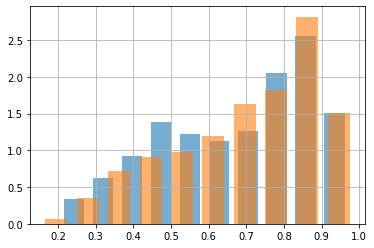

In [127]:
data_clean_analysis['pred'] = LogReg.predict(X)
data_clean_analysis['prob'] = LogReg.predict_proba(X)[:,1]

data_clean_analysis[where_female].prob.hist(rwidth=0.7, alpha=0.6, density=True)
data_clean_analysis[where_male].prob.hist(rwidth=0.7, alpha=0.6, density=True)

In [128]:
# Analyse contrefactuelle

In [129]:
data_contrefact = data_clean_analysis.copy()

In [130]:
def change_sex(x):
  if x == 0:
    return 1
  else:
    return 0

In [131]:
data_contrefact['sex'] = data_contrefact['sex'].apply(lambda x: change_sex(x))
X_contrefact = data_contrefact[feat_col]

data_contrefact['pred'] = LogReg.predict(X_contrefact)
data_contrefact['prob'] = LogReg.predict_proba(X_contrefact)[:,1]

In [132]:
good_risk_female_rate = data_clean_analysis[where_female]['pred'].mean()
good_risk_male_rate = data_clean_analysis[where_male]['pred'].mean()

where_female_contrefact = data_contrefact['sex'] == 1
where_male_contrefact = data_contrefact['sex'] == 0

good_risk_female_rate_cf = data_contrefact[where_female_contrefact]['pred'].mean()
good_risk_male_rate_cf = data_contrefact[where_male_contrefact]['pred'].mean()

print('----- INITIAL COMPUTATIONS -----')
print('Proportion of Good Risk for female: {}'.format(good_risk_female_rate))
print('Proportion of Good Risk for male: {}'.format(good_risk_male_rate))
print('\n')
print('----- CONTREFACTUAL COMPUTATIONS -----')
print('Proportion of Good Risk for female: {}'.format(good_risk_female_rate_cf))
print('Proportion of Good Risk for male: {}'.format(good_risk_male_rate_cf))

----- INITIAL COMPUTATIONS -----
Proportion of Good Risk for female: 0.7580645161290323
Proportion of Good Risk for male: 0.8159420289855073


----- CONTREFACTUAL COMPUTATIONS -----
Proportion of Good Risk for female: 0.7927536231884058
Proportion of Good Risk for male: 0.7774193548387097


<h3>Fairness Analysis</h3>

In [133]:
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

In [134]:
df_aif_ground_truth = BinaryLabelDataset(df=data_test, 
                            label_names=['target'], 
                            protected_attribute_names=['sex'])
df_aif_pred = BinaryLabelDataset(df=data_test_pred, 
                            label_names=['target'], 
                            protected_attribute_names=['sex'])

In [135]:
privileged_group = [{'sex': 0}]
unprivileged_group = [{'sex': 1}]

In [136]:
classif_metric = ClassificationMetric(df_aif_ground_truth,
                                      df_aif_pred,
                                      unprivileged_group, 
                                      privileged_group)

Many metrics of fairness are available, in the following cells, we compute:
<ul>
  <li> The Statistical Parity Difference 
  $$ SP = \mathbf{P}(f(X)=1 \, | \, S=1) - \mathbf{P}(f(X)=1 \, | \, S=0). $$ </li>
  <li> The Equal Opportunity Difference
  $$ EO = \mathbf{P}(f(X)=1 \, | \, S=1, Y=1) - \mathbf{P}(f(X)=1 \, | \, S=0, Y=1). $$ </li>
  <li> The Average Odds Difference 
  $$ AO = \frac{1}{2} \Big( \big[ \mathbf{P}(f(X)=1 \, | \, S=1, Y=0) - \mathbf{P}(f(X)=1 \, | \, S=0, Y=0) \big]  \\ 
    + \big[ \mathbf{P}(f(X)=1 \, | \, S=1, Y=1) - \mathbf{P}(f(X)=1 \, | \, S=0, Y=1) \big]   \Big). $$
  </li>

  <li>The Disparate Impact  
  $$ DI = \frac{\mathbf{P}(f(X)=1 \, | \, S=1)}{ \mathbf{P}(f(X)=1 \, | \, S=0)}. $$
  </li>
</ul>

In [137]:
# Statistical Parity
classif_metric.statistical_parity_difference()

-0.10886927280369896

In [138]:
# Equal Opportunity Difference
classif_metric.equal_opportunity_difference()

-0.047101449275362306

In [139]:
# Average Odds Difference
classif_metric.average_odds_difference()

-0.04999303232998886

In [140]:
# Disparate Impact
classif_metric.disparate_impact()

0.8722879684418147